## Jupyter Notebook for the creation of mdtraj obtained data plots and PCA/tICA analysis


- First you need to import the important libraries. Maybe you need to add more libraries. Feel free to add them in this first cell
- Then you can load the functions that will be used later on. Nice_PES ia a function for plotting FEL plots in a nice way


In [1]:
# Useful stuff
import numpy as np
from itertools import combinations
import os
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import pandas as pd
import pytraj as pt
import glob

# PyEmma
import pyemma
import pyemma.msm as msm
import pyemma.plots as mpl
import pyemma.coordinates as coor

In [2]:
def plot_Nice_PES(P_test,bins=90,sigma=0.99, title=False, size = 1):

    mpl.style.use("seaborn-paper")
    plt.figure(figsize=(6*size,5*size))
    alldata=np.vstack(P_test)
    min1=np.min(alldata[:,0])
    max1=np.max(alldata[:,0])
    min2=np.min(alldata[:,1])
    max2=np.max(alldata[:,1])
    
    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,0], alldata[:,1], bins=bins)
    z += 0.1
    
    # compute free energies
    F = -np.log(z)
    
    
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    
    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=10)
    plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    plt.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)
    if title:
        plt.title(title, fontsize = 20*size, y=1.02)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
    cax = plt.axes([0.81, 0.1, 0.02, 0.7])
    plt.colorbar(cax=cax, format='%.1f').set_label('Free energy (kcal/mol)', fontsize=10*size, labelpad=5, y= 0.5)
    cax.axes.tick_params(labelsize=10*size)

In [3]:
import matplotlib as mpl
#import nglview as nv
import ipywidgets as widgets
import pytraj as pt
import warnings
import tqdm
warnings.filterwarnings("ignore")
%pylab inline
%matplotlib inline

def interactive_FEL2(TICA_test, trajfiles, topfile, output_plot=True, n_frames=1,output_structure=False, size=1, bins=90, sigma=0.99, pc1=0, pc2=1):
    '''
        
        Plot the Free Energy Surface(FES) of the given data in a matplotlib pyqt. User can select a point in the FES. 
        
                
        If you experience some problem or you have any comment with this function --> https://github.com/miqueleg/compbiolab :3
        
        Parameters: ---------------------------------------------------------------------------------
        
        data: 3D ndarray (MD,frames,tic_dim). If not, the calculations will be wrong!!
        
        trajfiles: 1D array containing all trajectories strings containing files path and name(order in the list is important)
        
        topfile: string containing file path and name for the .pdb file that will be used as topology.
        
        output_plot: If true, a plot including the FES and selected pint will be displayed at the end.
            default=True
            
        output_structure: If True,the selected structure is also returned as pytraj structure.
            default=False
            
        size: Float/Integer that defines the size of the plots
            default=1
            
        
        Returns: -------------------------------------------------------------------------------------------
        
        - nglview of the structure selected
        
        - If output_structure=True, the selected structure is also returned as pytraj structure
        
        Only in in jupyter-notebook
          
    '''
    ##This imports are kind of necessary in order to plot the graphic in the Tk canvas(PQt5).
    ## At the end of the function, the matplotlib inline canvas has to be setted again in order to do not disturbe next plots
    %matplotlib qt

    ##Plot the Free energy surface as Nice_PES function
    mpl.style.use("seaborn-paper")
    fig, ax = plt.subplots(figsize=(6*size,5*size))
    alldata=np.vstack(TICA_test)
    min1=np.min(alldata[:,pc1])
    max1=np.max(alldata[:,pc1])
    min2=np.min(alldata[:,pc2])
    max2=np.max(alldata[:,pc2])
    print(all_data.shape)

    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,pc1], alldata[:,pc2], bins=bins)
    z += 0.1

    # compute free energies
    F = -np.log(z)

    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]

    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=8)
    ax.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    ax.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)

    ##ginput will wait until a click is done into the plot and collect the coordinates into the x variable
    x = plt.ginput()


    #nodes are the prepared data corresponding of the points on the TICA scatter (tic0 and tic1 by default)
    nodes = np.array(list(zip(alldata[:,pc1],alldata[:,pc2])))
    node = np.array(x[0])
    #cdist finction computes the distance matrix between TICA nodes and node
    distances = np.array(cdist([node], nodes))
    #clicked frame is the position in the matrix distance in wich you can find the minimun value
    clicked_frames = np.argsort(distances)[0]
    clicked_frames = clicked_frames[:n_frames]
    MD_out = pt.Trajectory(top=topfile)
    
    for f in tqdm.tqdm(range(len(clicked_frames))):
        clicked_frame = clicked_frames[f]
        MD=pt.iterload(trajfiles, top=topfile)
        MD_out.append(MD[clicked_frame])

        #Frames is a list containing the len of all the MD's.
        #This forces the input TICA_test to have a 3D shape (MD,frames,tic_dim). If not, the calculations are wrong!!
        Frames = []
        for traj in TICA_test:
            Frames.append(len(traj))
        #In this loop is computed in wich MD and MD_frame you can find the clicked frame
        MD = 0
        Frame = clicked_frame
        for i in list(range(len(Frames))):
            sum_frames = sum([Frames[j] for j in list(range(len(Frames))) if j <= i])
            if clicked_frame <= sum_frames:
                MD = i
                Frame = clicked_frame - sum([Frames[j] for j in list(range(len(Frames))) if j < i])
                break
            else:
                continue
    #The selected_frame is displayed using pytraj and nglview
    MD=pt.iterload(trajfiles, top=topfile)
    view=nv.show_pytraj(MD)
    view.clear()
    view.add_cartoon(selection="protein")
    view.frame = int(clicked_frame)

    #returning to the matplotlib inline
    %matplotlib inline
    #plot the selected position with a scatter
    if output_plot:
        plt.figure(figsize=(6*size,5*size))
        plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
        plt.contourf(data,alpha=0.2,cmap='jet', cbar=True,levels=levels,extent=extent)
        plt.scatter(np.array(x)[:,0],np.array(x)[:,1], c ='b', s =50)
    if output_structure:
        return view, MD_out
    else:
        return view


Populating the interactive namespace from numpy and matplotlib


# 1 - Discretization

I start by defining the input files names and the input coordinates

In [4]:
directo='/home/janet/Desktop/HSVTK/APO/'
trajfiles_APO=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_APO='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO.pdb'

directo='/home/janet/Desktop/HSVTK/APO_MG/'
trajfiles_APOMG=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_APOMG='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO_MG.pdb'

directo='/home/janet/Desktop/HSVTK/THM/'
trajfiles_THM=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM.pdb'

directo='/home/janet/Desktop/HSVTK/GCV/'
trajfiles_GCV=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV.pdb'

directo='/home/janet/Desktop/HSVTK/THM_ATP/'
trajfiles_THM_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM_ATP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM_ATP.pdb'

directo='/home/janet/Desktop/HSVTK/GCV_ATP/'
trajfiles_GCV_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV_ATP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV_ATP.pdb'

directo='/home/janet/Desktop/HSVTK/TMP_ADP/'
trajfiles_TMP_ADP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_TMP_ADP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_TMP_ADP.pdb'

directo='/home/janet/Desktop/HSVTK/GMP_ADP/'
trajfiles_GMP_ADP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GMP_ADP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GMP_ADP.pdb'


#--------------------MUT-------------------------#

directo='/home/janet/Desktop/HSVTK/SR39/'
trajfiles_SR39=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_SR39='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_SR39.pdb'


directo='/home/janet/Desktop/HSVTK/SR39_woATP/'
trajfiles_SR39_woATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_SR39_woATP='/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_SR39_woATP.pdb'

#-----------------------------#

directo='/home/janet/Desktop/HSVTK/CRYST/'
crystraj=[fi for fi in glob.glob(directo + '*ATP.dcd')]
crystop='/home/janet/Desktop/HSVTK/CRYST/1E2K_cryst_align.pdb'

In [5]:
trajfiles_GCV_ATP

['/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP1_super.dcd',
 '/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP2_super.dcd',
 '/home/janet/Desktop/HSVTK/GCV_ATP/dyn_MD_1E2K_GCV_ATP3_super.dcd']

In [5]:
trajfiles = []
trajfiles.append(trajfiles_APO)
trajfiles.append(trajfiles_APOMG)
trajfiles.append(trajfiles_THM)
trajfiles.append(trajfiles_GCV)
trajfiles.append(trajfiles_THM_ATP)
trajfiles.append(trajfiles_GCV_ATP)
trajfiles.append(trajfiles_TMP_ADP)
trajfiles.append(trajfiles_GMP_ADP)

topfiles = []
topfiles.append(topfile_APO)
topfiles.append(topfile_APOMG)
topfiles.append(topfile_THM)
topfiles.append(topfile_GCV)
topfiles.append(topfile_THM_ATP)
topfiles.append(topfile_GCV_ATP)
topfiles.append(topfile_TMP_ADP)
topfiles.append(topfile_GMP_ADP)


In [10]:
trajfiles

[['/home/janet/Desktop/HSVTK/APO/dyn_MD_1E2K_APO_super.dcd',
  '/home/janet/Desktop/HSVTK/APO/dyn_MD_1E2K_APO2_super.dcd',
  '/home/janet/Desktop/HSVTK/APO/dyn_MD_1E2K_APO3_super.dcd'],
 ['/home/janet/Desktop/HSVTK/APO_MG/dyn_MD_1E2K_APO_MG1_super.dcd',
  '/home/janet/Desktop/HSVTK/APO_MG/dyn_MD_1E2K_APO_MG2_super.dcd',
  '/home/janet/Desktop/HSVTK/APO_MG/dyn_MD_1E2K_APO_MG3_super.dcd'],
 ['/home/janet/Desktop/HSVTK/THM/dyn_MD_1E2K_THM1_super.dcd',
  '/home/janet/Desktop/HSVTK/THM/dyn_MD_1E2K_THM2_super.dcd',
  '/home/janet/Desktop/HSVTK/THM/dyn_MD_1E2K_THM3_super.dcd'],
 ['/home/janet/Desktop/HSVTK/GCV/dyn_MD_1E2K_GCV_super.dcd',
  '/home/janet/Desktop/HSVTK/GCV/dyn_MD_1E2K_GCV2_super.dcd',
  '/home/janet/Desktop/HSVTK/GCV/dyn_MD_1E2K_GCV3_super.dcd'],
 ['/home/janet/Desktop/HSVTK/THM_ATP/dyn_MD_1E2K_THM_ATP1_super.dcd',
  '/home/janet/Desktop/HSVTK/THM_ATP/dyn_MD_1E2K_THM_ATP2_super.dcd',
  '/home/janet/Desktop/HSVTK/THM_ATP/dyn_MD_1E2K_THM_ATP3_super.dcd'],
 ['/home/janet/Desktop/HS

In [11]:
topfiles

['/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_APO_MG.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_THM_ATP.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GCV_ATP.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_TMP_ADP.pdb',
 '/home/janet/Desktop/HSVTK/TOPS/MD_1E2K_GMP_ADP.pdb']

## analysis:

We normaly organize the data as the following: 
- FEATS are the lists variables that contains the data that will be used to extract info from the MD's (only based in the topfile). Feats list contain the feats for all systems. ej: feat1 == feats[0]
- SOURCES are the arrays containing the values of the feats for all frames

# PCA / TICA

In [6]:
SYS1 = pt.iterload(trajfiles[0], top=topfiles[0])
SYS2 = pt.iterload(trajfiles[1], top=topfiles[1])
SYS3 = pt.iterload(trajfiles[2], top=topfiles[2])
SYS4 = pt.iterload(trajfiles[3], top=topfiles[3])
SYS5 = pt.iterload(trajfiles[4], top=topfiles[4])
SYS6 = pt.iterload(trajfiles[5], top=topfiles[5])
SYS7 = pt.iterload(trajfiles[6], top=topfiles[6])
SYS8 = pt.iterload(trajfiles[7], top=topfiles[7])

In [40]:
# SYS1_rmsd_A = pt.rmsd(SYS1, mask=':206-238@CA', ref=SYS1[0])
# SYS2_rmsd_A = pt.rmsd(SYS2, mask=':206-238@CA', ref=SYS2[0])
# SYS3_rmsd_A = pt.rmsd(SYS3, mask=':206-238@CA', ref=SYS3[0])
# SYS4_rmsd_A = pt.rmsd(SYS4, mask=':206-238@CA', ref=SYS4[0])
# SYS5_rmsd_A = pt.rmsd(SYS5, mask=':206-238@CA', ref=SYS5[0])
# SYS6_rmsd_A = pt.rmsd(SYS6, mask=':206-238@CA', ref=SYS6[0])
# SYS7_rmsd_A = pt.rmsd(SYS7, mask=':206-238@CA', ref=SYS7[0])
# SYS8_rmsd_A = pt.rmsd(SYS8, mask=':206-238@CA', ref=SYS8[0])
SYS9_rmsd_A = pt.rmsd(SYS9, mask=':206-238@CA', ref=SYS9[0])

In [41]:
# SYS1_rmsd_B = pt.rmsd(SYS1, mask=':535-567@CA', ref=SYS1[0])
# SYS2_rmsd_B = pt.rmsd(SYS2, mask=':535-567@CA', ref=SYS2[0])
# SYS3_rmsd_B = pt.rmsd(SYS3, mask=':535-567@CA', ref=SYS3[0])
# SYS4_rmsd_B = pt.rmsd(SYS4, mask=':535-567@CA', ref=SYS4[0])
# SYS5_rmsd_B = pt.rmsd(SYS5, mask=':535-567@CA', ref=SYS5[0])
# SYS6_rmsd_B = pt.rmsd(SYS6, mask=':535-567@CA', ref=SYS6[0])
# SYS7_rmsd_B = pt.rmsd(SYS7, mask=':535-567@CA', ref=SYS7[0])
# SYS8_rmsd_B = pt.rmsd(SYS8, mask=':535-567@CA', ref=SYS8[0])
SYS9_rmsd_B = pt.rmsd(SYS9, mask=':535-567@CA', ref=SYS9[0])

In [42]:
# SYS1_dh_A = pt.dihedral(SYS1, '@800 @2777 @2515 @2694')
# SYS2_dh_A = pt.dihedral(SYS2, '@800 @2777 @2515 @2694')
# SYS3_dh_A = pt.dihedral(SYS3, '@800 @2777 @2515 @2694')
# SYS4_dh_A = pt.dihedral(SYS4, '@800 @2777 @2515 @2694')
# SYS5_dh_A = pt.dihedral(SYS5, '@800 @2777 @2515 @2694')
# SYS6_dh_A = pt.dihedral(SYS6, '@800 @2777 @2515 @2694')
# SYS7_dh_A = pt.dihedral(SYS7, '@800 @2777 @2515 @2694')
# SYS8_dh_A = pt.dihedral(SYS8, '@800 @2777 @2515 @2694')
SYS9_dh_A = pt.dihedral(SYS9, '@800 @2777 @2515 @2694')


# SYS1_dh_A = np.abs(SYS1_dh_A)
# SYS2_dh_A = np.abs(SYS2_dh_A)
# SYS3_dh_A = np.abs(SYS3_dh_A)
# SYS4_dh_A = np.abs(SYS4_dh_A)
# SYS5_dh_A = np.abs(SYS5_dh_A)
# SYS6_dh_A = np.abs(SYS6_dh_A)
# SYS7_dh_A = np.abs(SYS7_dh_A)
# SYS8_dh_A = np.abs(SYS8_dh_A)
SYS9_dh_A = np.abs(SYS9_dh_A)

In [43]:
# SYS1_dh_B = pt.dihedral(SYS1, '@5807 @7784 @7522 @7701')
# SYS2_dh_B = pt.dihedral(SYS2, '@5807 @7784 @7522 @7701')
# SYS3_dh_B = pt.dihedral(SYS3, '@5807 @7784 @7522 @7701')
# SYS4_dh_B = pt.dihedral(SYS4, '@5807 @7784 @7522 @7701')
# SYS5_dh_B = pt.dihedral(SYS5, '@5807 @7784 @7522 @7701')
# SYS6_dh_B = pt.dihedral(SYS6, '@5807 @7784 @7522 @7701')
# SYS7_dh_B = pt.dihedral(SYS7, '@5807 @7784 @7522 @7701')
# SYS8_dh_B = pt.dihedral(SYS8, '@5807 @7784 @7522 @7701')
SYS9_dh_B = pt.dihedral(SYS9, '@5807 @7784 @7522 @7701')

# SYS1_dh_B = np.abs(SYS1_dh_B)
# SYS2_dh_B = np.abs(SYS2_dh_B)
# SYS3_dh_B = np.abs(SYS3_dh_B)
# SYS4_dh_B = np.abs(SYS4_dh_B)
# SYS5_dh_B = np.abs(SYS5_dh_B)
# SYS6_dh_B = np.abs(SYS6_dh_B)
# SYS7_dh_B = np.abs(SYS7_dh_B)
# SYS8_dh_B = np.abs(SYS8_dh_B)
SYS9_dh_B = np.abs(SYS9_dh_B)

In [44]:
# SYS1_rg_A = pt.radgyr(SYS1, mask=':206-238@CA')
# SYS2_rg_A = pt.radgyr(SYS2, mask=':206-238@CA')
# SYS3_rg_A = pt.radgyr(SYS3, mask=':206-238@CA')
# SYS4_rg_A = pt.radgyr(SYS4, mask=':206-238@CA')
# SYS5_rg_A = pt.radgyr(SYS5, mask=':206-238@CA')
# SYS6_rg_A = pt.radgyr(SYS6, mask=':206-238@CA')
# SYS7_rg_A = pt.radgyr(SYS7, mask=':206-238@CA')
# SYS8_rg_A = pt.radgyr(SYS8, mask=':206-238@CA')
SYS9_rg_A = pt.radgyr(SYS9, mask=':206-238@CA')

In [45]:
# SYS1_rg_B = pt.radgyr(SYS1, mask=':535-567@CA')
# SYS2_rg_B = pt.radgyr(SYS2, mask=':535-567@CA')
# SYS3_rg_B = pt.radgyr(SYS3, mask=':535-567@CA')
# SYS4_rg_B = pt.radgyr(SYS4, mask=':535-567@CA')
# SYS5_rg_B = pt.radgyr(SYS5, mask=':535-567@CA')
# SYS6_rg_B = pt.radgyr(SYS6, mask=':535-567@CA')
# SYS7_rg_B = pt.radgyr(SYS7, mask=':535-567@CA')
# SYS8_rg_B = pt.radgyr(SYS8, mask=':535-567@CA')
SYS9_rg_B = pt.radgyr(SYS9, mask=':535-567@CA')

In [7]:
SYS5_catglu_A = pt.distance(SYS5, ':38@CD :661@O3')
SYS5_catglu_B = pt.distance(SYS5, ':367@CD :662@O3')
SYS5_catatp_A = pt.distance(SYS5, ':663@PG :661@O3')
SYS5_catatp_B = pt.distance(SYS5, ':664@PG :662@O3')

SYS6_catglu_A = pt.distance(SYS6, ':38@CD :661@O3')
SYS6_catglu_B = pt.distance(SYS6, ':367@CD :662@O3')
SYS6_catatp_A = pt.distance(SYS6, ':663@PG :661@O3')
SYS6_catatp_B = pt.distance(SYS6, ':664@PG :662@O3')

SYS9_catglu_A = pt.distance(SYS9, ':38@CD :661@O3')
SYS9_catglu_B = pt.distance(SYS9, ':367@CD :662@O3')
SYS9_catatp_A = pt.distance(SYS9, ':663@PG :661@O3')
SYS9_catatp_B = pt.distance(SYS9, ':664@PG :662@O3')


SYS5_catglu_A = np.hstack(SYS5_catglu_A)
SYS5_catglu_B = np.hstack(SYS5_catglu_B) 
SYS5_catatp_A = np.hstack(SYS5_catatp_A)
SYS5_catatp_B = np.hstack(SYS5_catatp_B) 

SYS6_catglu_A = np.hstack(SYS6_catglu_A)
SYS6_catglu_B = np.hstack(SYS6_catglu_B) 
SYS6_catatp_A = np.hstack(SYS6_catatp_A) 
SYS6_catatp_B = np.hstack(SYS6_catatp_B) 

SYS9_catglu_A = np.hstack(SYS9_catglu_A)
SYS9_catglu_B = np.hstack(SYS9_catglu_B) 
SYS9_catatp_A = np.hstack(SYS9_catatp_A) 
SYS9_catatp_B = np.hstack(SYS9_catatp_B) 

NameError: name 'SYS9' is not defined

In [38]:
SYS5_catglu_A

array([4.96988062, 4.72882463, 5.77448901, ..., 4.69479576, 5.09960624,
       5.07351491])

In [47]:
import pickle

# pickle.dump(SYS1_rmsd_A, open ("ALLVAR_TRAJS/SYS1_rmsd_A.p", "wb"))
# pickle.dump(SYS2_rmsd_A, open ("ALLVAR_TRAJS/SYS2_rmsd_A.p", "wb"))
# pickle.dump(SYS3_rmsd_A, open ("ALLVAR_TRAJS/SYS3_rmsd_A.p", "wb"))
# pickle.dump(SYS4_rmsd_A, open ("ALLVAR_TRAJS/SYS4_rmsd_A.p", "wb"))
# pickle.dump(SYS5_rmsd_A, open ("ALLVAR_TRAJS/SYS5_rmsd_A.p", "wb"))
# pickle.dump(SYS6_rmsd_A, open ("ALLVAR_TRAJS/SYS6_rmsd_A.p", "wb"))
# pickle.dump(SYS7_rmsd_A, open ("ALLVAR_TRAJS/SYS7_rmsd_A.p", "wb"))
# pickle.dump(SYS8_rmsd_A, open ("ALLVAR_TRAJS/SYS8_rmsd_A.p", "wb"))
pickle.dump(SYS9_rmsd_A, open ("ALLVAR_TRAJS/SYS9_rmsd_A.p", "wb"))

# pickle.dump(SYS1_rmsd_B, open ("ALLVAR_TRAJS/SYS1_rmsd_B.p", "wb"))
# pickle.dump(SYS2_rmsd_B, open ("ALLVAR_TRAJS/SYS2_rmsd_B.p", "wb"))
# pickle.dump(SYS3_rmsd_B, open ("ALLVAR_TRAJS/SYS3_rmsd_B.p", "wb"))
# pickle.dump(SYS4_rmsd_B, open ("ALLVAR_TRAJS/SYS4_rmsd_B.p", "wb"))
# pickle.dump(SYS5_rmsd_B, open ("ALLVAR_TRAJS/SYS5_rmsd_B.p", "wb"))
# pickle.dump(SYS6_rmsd_B, open ("ALLVAR_TRAJS/SYS6_rmsd_B.p", "wb"))
# pickle.dump(SYS7_rmsd_B, open ("ALLVAR_TRAJS/SYS7_rmsd_B.p", "wb"))
# pickle.dump(SYS8_rmsd_B, open ("ALLVAR_TRAJS/SYS8_rmsd_B.p", "wb"))
pickle.dump(SYS9_rmsd_B, open ("ALLVAR_TRAJS/SYS9_rmsd_B.p", "wb"))


# pickle.dump(SYS1_dh_A, open ("ALLVAR_TRAJS/SYS1_dh_A.p", "wb"))
# pickle.dump(SYS2_dh_A, open ("ALLVAR_TRAJS/SYS2_dh_A.p", "wb"))
# pickle.dump(SYS3_dh_A, open ("ALLVAR_TRAJS/SYS3_dh_A.p", "wb"))
# pickle.dump(SYS4_dh_A, open ("ALLVAR_TRAJS/SYS4_dh_A.p", "wb"))
# pickle.dump(SYS5_dh_A, open ("ALLVAR_TRAJS/SYS5_dh_A.p", "wb"))
# pickle.dump(SYS6_dh_A, open ("ALLVAR_TRAJS/SYS6_dh_A.p", "wb"))
# pickle.dump(SYS7_dh_A, open ("ALLVAR_TRAJS/SYS7_dh_A.p", "wb"))
# pickle.dump(SYS8_dh_A, open ("ALLVAR_TRAJS/SYS8_dh_A.p", "wb"))
pickle.dump(SYS9_dh_A, open ("ALLVAR_TRAJS/SYS9_dh_A.p", "wb"))



# pickle.dump(SYS1_dh_B, open ("ALLVAR_TRAJS/SYS1_dh_B.p", "wb"))
# pickle.dump(SYS2_dh_B, open ("ALLVAR_TRAJS/SYS2_dh_B.p", "wb"))
# pickle.dump(SYS3_dh_B, open ("ALLVAR_TRAJS/SYS3_dh_B.p", "wb"))
# pickle.dump(SYS4_dh_B, open ("ALLVAR_TRAJS/SYS4_dh_B.p", "wb"))
# pickle.dump(SYS5_dh_B, open ("ALLVAR_TRAJS/SYS5_dh_B.p", "wb"))
# pickle.dump(SYS6_dh_B, open ("ALLVAR_TRAJS/SYS6_dh_B.p", "wb"))
# pickle.dump(SYS7_dh_B, open ("ALLVAR_TRAJS/SYS7_dh_B.p", "wb"))
# pickle.dump(SYS8_dh_B, open ("ALLVAR_TRAJS/SYS8_dh_B.p", "wb"))
pickle.dump(SYS9_dh_B, open ("ALLVAR_TRAJS/SYS9_dh_B.p", "wb"))


# pickle.dump(SYS1_rg_A, open ("ALLVAR_TRAJS/SYS1_rg_A.p", "wb"))
# pickle.dump(SYS2_rg_A, open ("ALLVAR_TRAJS/SYS2_rg_A.p", "wb"))
# pickle.dump(SYS3_rg_A, open ("ALLVAR_TRAJS/SYS3_rg_A.p", "wb"))
# pickle.dump(SYS4_rg_A, open ("ALLVAR_TRAJS/SYS4_rg_A.p", "wb"))
# pickle.dump(SYS5_rg_A, open ("ALLVAR_TRAJS/SYS5_rg_A.p", "wb"))
# pickle.dump(SYS6_rg_A, open ("ALLVAR_TRAJS/SYS6_rg_A.p", "wb"))
# pickle.dump(SYS7_rg_A, open ("ALLVAR_TRAJS/SYS7_rg_A.p", "wb"))
# pickle.dump(SYS8_rg_A, open ("ALLVAR_TRAJS/SYS8_rg_A.p", "wb"))
pickle.dump(SYS9_rg_A, open ("ALLVAR_TRAJS/SYS9_rg_A.p", "wb"))


# pickle.dump(SYS1_rg_B, open ("ALLVAR_TRAJS/SYS1_rg_B.p", "wb"))
# pickle.dump(SYS2_rg_B, open ("ALLVAR_TRAJS/SYS2_rg_B.p", "wb"))
# pickle.dump(SYS3_rg_B, open ("ALLVAR_TRAJS/SYS3_rg_B.p", "wb"))
# pickle.dump(SYS4_rg_B, open ("ALLVAR_TRAJS/SYS4_rg_B.p", "wb"))
# pickle.dump(SYS5_rg_B, open ("ALLVAR_TRAJS/SYS5_rg_B.p", "wb"))
# pickle.dump(SYS6_rg_B, open ("ALLVAR_TRAJS/SYS6_rg_B.p", "wb"))
# pickle.dump(SYS7_rg_B, open ("ALLVAR_TRAJS/SYS7_rg_B.p", "wb"))
# pickle.dump(SYS8_rg_B, open ("ALLVAR_TRAJS/SYS8_rg_B.p", "wb"))
pickle.dump(SYS9_rg_B, open ("ALLVAR_TRAJS/SYS9_rg_B.p", "wb"))


In [48]:
import pickle

SYS1_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS1_rmsd_A.p", "rb"))
SYS2_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS2_rmsd_A.p", "rb"))
SYS3_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS3_rmsd_A.p", "rb"))
SYS4_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS4_rmsd_A.p", "rb"))
SYS5_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS5_rmsd_A.p", "rb"))
SYS6_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS6_rmsd_A.p", "rb"))
SYS7_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS7_rmsd_A.p", "rb"))
SYS8_rmsd_A=pickle.load(open("ALLVAR_TRAJS/SYS8_rmsd_A.p", "rb"))

SYS1_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS1_rmsd_B.p", "rb"))
SYS2_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS2_rmsd_B.p", "rb"))
SYS3_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS3_rmsd_B.p", "rb"))
SYS4_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS4_rmsd_B.p", "rb"))
SYS5_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS5_rmsd_B.p", "rb"))
SYS6_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS6_rmsd_B.p", "rb"))
SYS7_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS7_rmsd_B.p", "rb"))
SYS8_rmsd_B=pickle.load(open("ALLVAR_TRAJS/SYS8_rmsd_B.p", "rb"))

SYS1_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS1_dh_A.p", "rb"))
SYS2_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS2_dh_A.p", "rb"))
SYS3_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS3_dh_A.p", "rb"))
SYS4_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS4_dh_A.p", "rb"))
SYS5_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS5_dh_A.p", "rb"))
SYS6_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS6_dh_A.p", "rb"))
SYS7_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS7_dh_A.p", "rb"))
SYS8_dh_A= pickle.load(open("ALLVAR_TRAJS/SYS8_dh_A.p", "rb"))

SYS1_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS1_dh_B.p", "rb"))
SYS2_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS2_dh_B.p", "rb"))
SYS3_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS3_dh_B.p", "rb"))
SYS4_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS4_dh_B.p", "rb"))
SYS5_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS5_dh_B.p", "rb"))
SYS6_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS6_dh_B.p", "rb"))
SYS7_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS7_dh_B.p", "rb"))
SYS8_dh_B= pickle.load(open("ALLVAR_TRAJS/SYS8_dh_B.p", "rb"))

SYS1_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS1_rg_A.p", "rb"))
SYS2_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS2_rg_A.p", "rb"))
SYS3_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS3_rg_A.p", "rb"))
SYS4_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS4_rg_A.p", "rb"))
SYS5_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS5_rg_A.p", "rb"))
SYS6_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS6_rg_A.p", "rb"))
SYS7_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS7_rg_A.p", "rb"))
SYS8_rg_A= pickle.load(open("ALLVAR_TRAJS/SYS8_rg_A.p", "rb"))

SYS1_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS1_rg_B.p", "rb"))
SYS2_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS2_rg_B.p", "rb"))
SYS3_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS3_rg_B.p", "rb"))
SYS4_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS4_rg_B.p", "rb"))
SYS5_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS5_rg_B.p", "rb"))
SYS6_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS6_rg_B.p", "rb"))
SYS7_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS7_rg_B.p", "rb"))
SYS8_rg_B= pickle.load(open("ALLVAR_TRAJS/SYS8_rg_B.p", "rb"))


In [ ]:
SYS1_bf = pt.bfactors(SYS1)
SYS2_bf = pt.bfactors(SYS2)
SYS3_bf = pt.bfactors(SYS3)
SYS4_bf = pt.bfactors(SYS4)
SYS5_bf = pt.bfactors(SYS5)
SYS6_bf = pt.bfactors(SYS6)
SYS7_bf = pt.bfactors(SYS7)
SYS8_bf = pt.bfactors(SYS8)

In [ ]:
SYS1_bf

In [ ]:
plt.plot(SYS1_bf)

In [7]:
feat1=pyemma.coordinates.featurizer(topfiles[0])
all_Ca1=feat1.select_Ca()
feat1.add_selection(all_Ca1)

feat2=pyemma.coordinates.featurizer(topfiles[1])
all_Ca2=feat2.select_Ca()
feat2.add_selection(all_Ca2)

feat3=pyemma.coordinates.featurizer(topfiles[2])
all_Ca3=feat3.select_Ca()
print(all_Ca3)
feat3.add_selection(all_Ca3)

feat4=pyemma.coordinates.featurizer(topfiles[3])
all_Ca4=feat4.select_Ca()
print(all_Ca4)
feat4.add_selection(all_Ca4)

feat5=pyemma.coordinates.featurizer(topfiles[4])
all_Ca5=feat5.select_Ca()
print(all_Ca5)
feat5.add_selection(all_Ca5)

feat6=pyemma.coordinates.featurizer(topfiles[5])
all_Ca6=feat6.select_Ca()
print(all_Ca6)
feat6.add_selection(all_Ca6)

feat7=pyemma.coordinates.featurizer(topfiles[6])
all_Ca7=feat7.select_Ca()
print(all_Ca7)
feat7.add_selection(all_Ca7)

feat8=pyemma.coordinates.featurizer(topfiles[7])
all_Ca8=feat8.select_Ca()
print(all_Ca8)
feat8.add_selection(all_Ca8)


[    4    29    35 ...  9976  9993 10000]
[    4    29    35 ...  9976  9993 10000]
[    4    29    35 ...  9976  9993 10000]
[    4    29    35 ...  9976  9993 10000]
[    4    29    35 ...  9976  9993 10000]
[    4    29    35 ...  9976  9993 10000]


In [7]:
print(len(feat1.describe()))
print(len(feat2.describe()))
# print(len(feat3.describe()))
# print(len(feat4.describe()))
# print(len(feat5.describe()))
# print(len(feat6.describe()))
#print(len(feat7.describe()))
#print(len(feat8.describe()))
#print(len(feat9.describe()))

1974
1974


In [8]:
feats=[]
feats.append(feat1)
feats.append(feat2)
feats.append(feat3)
feats.append(feat4)
feats.append(feat5)
feats.append(feat6)
feats.append(feat7)
feats.append(feat8)

In [9]:
# This may take a while

sources=[]
print (len(feats[0].describe()))
for traj in range(0,len(topfiles)):
    print (traj,len(trajfiles))
    sources.append(pyemma.coordinates.load(trajfiles[traj],features=feats[traj]))

1974
0 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

1 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

2 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

3 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

4 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

5 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

6 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

7 8


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
joint_data = sources[0] + sources [1] + sources [2] + sources [3] + sources [4] + sources [5] + sources [6] + sources [7]

## PCA

- Here the PCA space is created using all the data from all the systems. This can be done if we have the same features for all the different systems.
- Later on, the data is splitted for the different systems, but the space is the same

In [12]:
pca_joint= pyemma.coordinates.pca(data=joint_data,kinetic_map=False,stride=1)
pca_Y = pca_joint.get_output()
pca_APO,pca_APOMG,pca_THM, pca_GCV, pca_THM_ATP, pca_GCV_ATP, pca_TMP_ADP, pca_GMP_ADP = np.split(pca_Y, np.cumsum(list(map(len, trajfiles)))[:-1])


calc mean+cov:   0%|          | 0/24 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/24 [00:00<?, ?it/s]

### Transform

In [27]:
featc=pyemma.coordinates.featurizer(crystop)
all_Cac=featc.select_Ca() # Features selected CA coordinates. The trajectories MUST be aligned first!
print(all_Cac)            # if you want to avoid the aligning, you can use: feat1.add_distances_ca()
featc.add_selection(all_Cac)

[   1   20   34 ... 9975 9992 9999]


In [28]:
cryssources = pyemma.coordinates.load(crystraj,features=featc)

In [29]:
pca_cryst = pca_joint.transform(cryssources)

# TRANSFORM MUTANT

In [18]:
###SR39
trajfiles.append(trajfiles_SR39)
topfiles.append(topfile_SR39)
###SR39 woATP
trajfiles.append(trajfiles_SR39_woATP)
topfiles.append(topfile_SR39_woATP)

In [19]:
##Comparing SR39 with GCV_ATP and THM_ATP system

featSR39=pyemma.coordinates.featurizer(topfiles[8])
all_CaSR39=featSR39.select_Ca() # Features selected CA coordinates. The trajectories MUST be aligned first!
print(all_CaSR39)            # if you want to avoid the aligning, you can use: feat1.add_distances_ca()
featSR39.add_selection(all_CaSR39)


##Comparing SR39 with GCV and THM system
featSR39_woATP=pyemma.coordinates.featurizer(topfiles[9])
all_CaSR39_woATP=featSR39_woATP.select_Ca()
print(all_CaSR39_woATP)            
featSR39_woATP.add_selection(all_CaSR39_woATP)



[    4    29    35 ...  9992 10009 10016]
[    4    29    35 ...  9992 10009 10016]


In [20]:
sourcesSR39 = pyemma.coordinates.load(trajfiles[8],features=featSR39)

sourcesSR39_woATP = pyemma.coordinates.load(trajfiles[9],features=featSR39_woATP)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
pca_SR39 = pca_joint.transform(sourcesSR39)

pca_SR39_woATP = pca_joint.transform(sourcesSR39_woATP)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

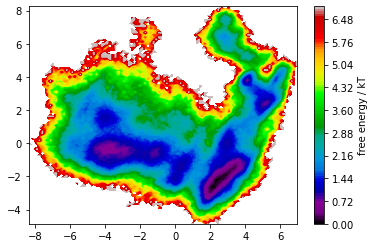

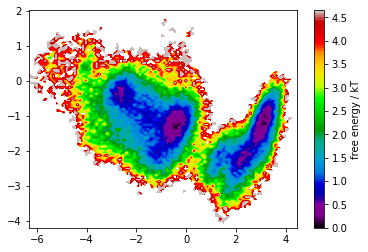

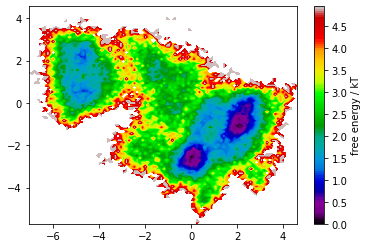

In [25]:
all_data=np.vstack(pca_Y)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
# plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
pyemma.plots.plot_free_energy(np.vstack(pca_SR39)[:,0],np.vstack(pca_SR39)[:,1])
pyemma.plots.plot_free_energy(np.vstack(pca_SR39_woATP)[:,0],np.vstack(pca_SR39_woATP)[:,1])

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

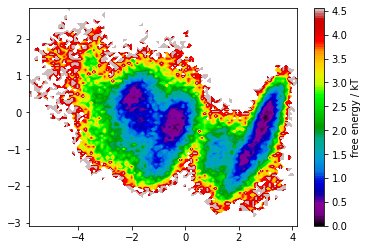

In [30]:
np.vstack(pca_SR39)

array([[ 0.8663094 , -1.53008633, -0.40543966, ..., -0.27330485,
         0.07212349,  0.97215668],
       [ 0.58813681, -1.56251958, -0.4084697 , ..., -0.23339645,
         0.11286695,  0.99836527],
       [ 0.66336501, -1.44129413, -0.55991122, ..., -0.06366174,
         0.07793531,  1.06284802],
       ...,
       [ 3.53204937,  0.79261633, -0.21341108, ..., -0.43878093,
         0.02329488,  1.05980974],
       [ 3.28048878,  0.8211653 , -0.21615707, ..., -0.3616171 ,
         0.0618328 ,  1.00580793],
       [ 3.32355006,  0.29414676, -0.25109152, ..., -0.25444641,
         0.00399947,  0.94088488]])

(-8.370796496868135, 6.9336155009269715, -4.857285401821136, 8.254633328914641)

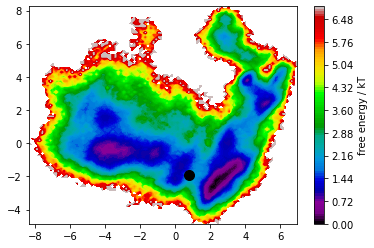

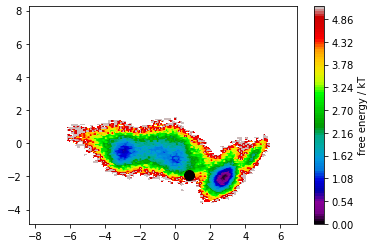

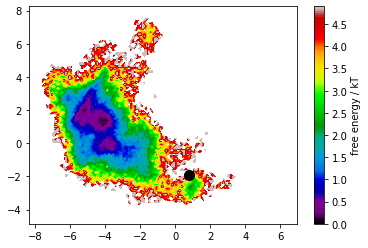

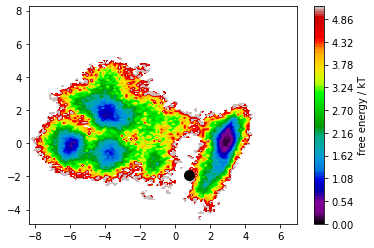

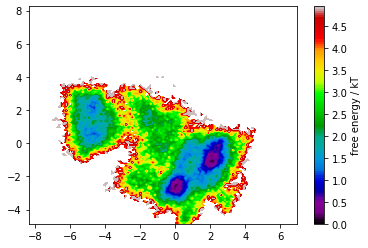

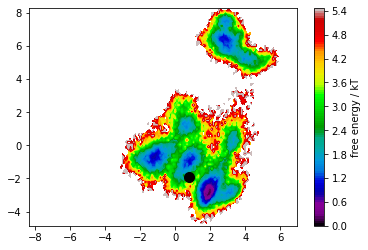

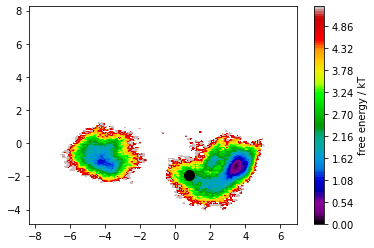

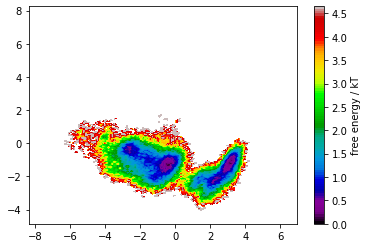

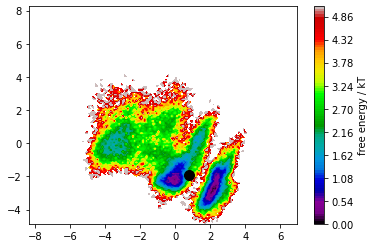

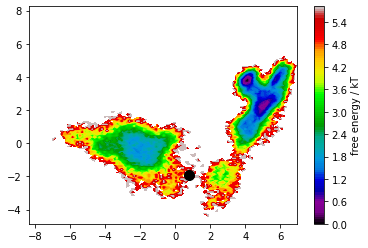

In [30]:
all_data=np.vstack(pca_Y)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
extend=axis()

all_data=np.vstack(pca_APO)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

all_data=np.vstack(pca_THM)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

all_data=np.vstack(pca_GCV)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

pyemma.plots.plot_free_energy(np.vstack(pca_SR39_woATP)[:,0],np.vstack(pca_SR39_woATP)[:,1])
axis(extend)

all_data=np.vstack(pca_THM_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

all_data=np.vstack(pca_GCV_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

pyemma.plots.plot_free_energy(np.vstack(pca_SR39)[:,0],np.vstack(pca_SR39)[:,1])
axis(extend)

all_data=np.vstack(pca_TMP_ADP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

all_data=np.vstack(pca_GMP_ADP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1])
plt.scatter(np.vstack(pca_cryst)[:,0], np.vstack(pca_cryst)[:,1], s=100, c='black')
axis(extend)

In [ ]:
all_rg=[]

all_rg.extend(SYS1_rmsd_A)
all_rg.extend(SYS2_rmsd_A)
all_rg.extend(SYS3_rmsd_A)
all_rg.extend(SYS4_rmsd_A)
all_rg.extend(SYS5_rmsd_A)
all_rg.extend(SYS6_rmsd_A)
all_rg.extend(SYS7_rmsd_A)
all_rg.extend(SYS8_rmsd_A)
all_rg.extend(SYS1_rmsd_B)
all_rg.extend(SYS2_rmsd_B)
all_rg.extend(SYS3_rmsd_B)
all_rg.extend(SYS4_rmsd_B)
all_rg.extend(SYS5_rmsd_B)
all_rg.extend(SYS6_rmsd_B)
all_rg.extend(SYS7_rmsd_B)
all_rg.extend(SYS8_rmsd_B)

In [ ]:
np.max(all_rg)

In [ ]:
def plot_overfel(P_test,feat,alpha,bins=90,sigma=0.99, title=False, size = 1):

    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    mpl.style.use("seaborn-paper")
    plt.figure(figsize=(6*size,5*size))
    alldata=np.vstack(P_test)
    cryst=np.vstack(pca_cryst)
    data=np.vstack(feat)
    min1=np.min(alldata[:,0])
    max1=np.max(alldata[:,0])
    min2=np.min(alldata[:,1])
    max2=np.max(alldata[:,1])
    
    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,0], alldata[:,1], bins=bins)
    z += 0.1
    
    # compute free energies
    F = -np.log(z)
    
    
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    
    # mpl.colors.ListedColormap(['magenta', 'orange','yellow'])
  
    # plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    #     cax= cax,
    #     ,
    #     spacing='uniform',
    #     orientation='vertical',
    #     label='Custom extension lengths, some other units')
    
    # colors=['skyblue','mediumorchid','hotpink','orange','yellow'] 
    # cmap = (ListedColormap(colors))
    # bounds = (0,30,60,100,160,180)
    
    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=10)
    plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    plt.contourf(data,alpha=0.2,cmap='gray', cbar=True,levels=levels,extent=extent)
    plt.scatter(alldata[:,0][0:75000], alldata[:,1][0:75000],c=feat, alpha=alpha,vmin=7,vmax=15, zorder=0,  cmap='jet')
    plt.title('APO', fontsize=25)
    plt.xlabel('PC0', fontsize=20)
    plt.ylabel('PC1', fontsize=20)
    if title:
        plt.title(title, fontsize = 20*size, y=1.02)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
    cax = plt.axes([0.81, 0.1, 0.02, 0.7])
    plt.colorbar(cax=cax,  format='%.1f').set_label('Radius of Gyration (Å)', fontsize=10*size, labelpad=5, y= 0.5)
    cax.axes.tick_params(labelsize=10*size)

In [ ]:
#mpl.cm.ScalarMappable(cmap=cmap),boundaries=bounds, ticks=bounds,

In [ ]:
plot_overfel(pca_APO, SYS1_rg_A,1,size=2)
plot_overfel(pca_APO, SYS1_rg_B,1, size=2)

In [ ]:
figure,(ax1,ax2,ax3,ax4) = plt.subplots(4,1)

ax1.scatter(SYS1_rg_A, SYS1_rmsd_A, c='black', alpha=0.2)
ax2.scatter(SYS1_rg_B, SYS1_rmsd_B, c='blue', alpha=0.2)

In [49]:
all_rmsd_A=[]

all_rmsd_A.extend(SYS1_rmsd_A)
all_rmsd_A.extend(SYS2_rmsd_A)
all_rmsd_A.extend(SYS3_rmsd_A)
all_rmsd_A.extend(SYS4_rmsd_A)
all_rmsd_A.extend(SYS5_rmsd_A)
all_rmsd_A.extend(SYS6_rmsd_A)
all_rmsd_A.extend(SYS7_rmsd_A)
all_rmsd_A.extend(SYS8_rmsd_A)
all_rmsd_A.extend(SYS9_rmsd_A)

all_rmsd_B= []
all_rmsd_B.extend(SYS1_rmsd_B)
all_rmsd_B.extend(SYS2_rmsd_B)
all_rmsd_B.extend(SYS3_rmsd_B)
all_rmsd_B.extend(SYS4_rmsd_B)
all_rmsd_B.extend(SYS5_rmsd_B)
all_rmsd_B.extend(SYS6_rmsd_B)
all_rmsd_B.extend(SYS7_rmsd_B)
all_rmsd_B.extend(SYS8_rmsd_B)
all_rmsd_B.extend(SYS9_rmsd_B)

In [50]:
all_rg_A=[]

all_rg_A.extend(SYS1_rg_A)
all_rg_A.extend(SYS2_rg_A)
all_rg_A.extend(SYS3_rg_A)
all_rg_A.extend(SYS4_rg_A)
all_rg_A.extend(SYS5_rg_A)
all_rg_A.extend(SYS6_rg_A)
all_rg_A.extend(SYS7_rg_A)
all_rg_A.extend(SYS8_rg_A)
all_rg_A.extend(SYS9_rg_A)

all_rg_B=[]

all_rg_B.extend(SYS1_rg_B)
all_rg_B.extend(SYS2_rg_B)
all_rg_B.extend(SYS3_rg_B)
all_rg_B.extend(SYS4_rg_B)
all_rg_B.extend(SYS5_rg_B)
all_rg_B.extend(SYS6_rg_B)
all_rg_B.extend(SYS7_rg_B)
all_rg_B.extend(SYS8_rg_B)
all_rg_B.extend(SYS9_rg_B)

In [51]:
all_dh_A=[]

all_dh_A.extend(SYS1_dh_A)
all_dh_A.extend(SYS2_dh_A)
all_dh_A.extend(SYS3_dh_A)
all_dh_A.extend(SYS4_dh_A)
all_dh_A.extend(SYS5_dh_A)
all_dh_A.extend(SYS6_dh_A)
all_dh_A.extend(SYS7_dh_A)
all_dh_A.extend(SYS8_dh_A)
all_dh_A.extend(SYS9_dh_A)

all_dh_B=[]

all_dh_B.extend(SYS1_dh_B)
all_dh_B.extend(SYS2_dh_B)
all_dh_B.extend(SYS3_dh_B)
all_dh_B.extend(SYS4_dh_B)
all_dh_B.extend(SYS5_dh_B)
all_dh_B.extend(SYS6_dh_B)
all_dh_B.extend(SYS7_dh_B)
all_dh_B.extend(SYS8_dh_B)
all_dh_B.extend(SYS9_dh_B)

In [ ]:
all_dh

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

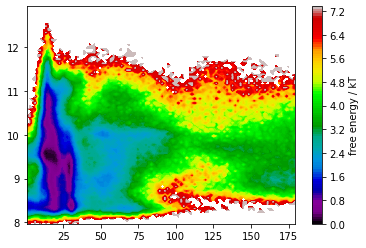

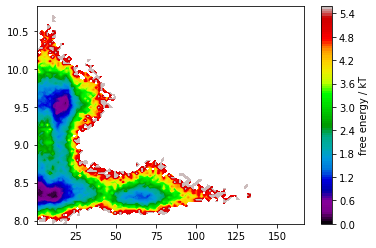

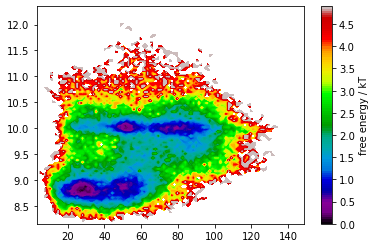

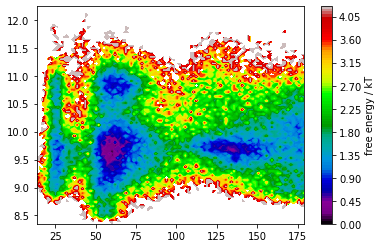

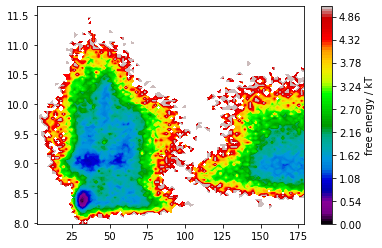

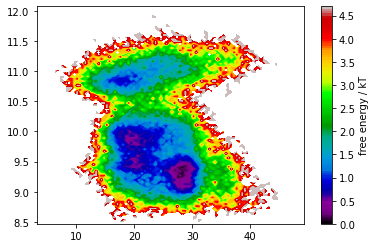

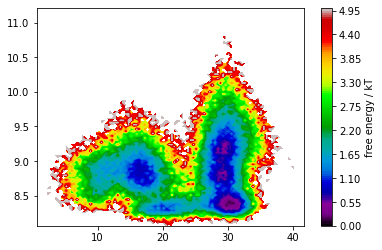

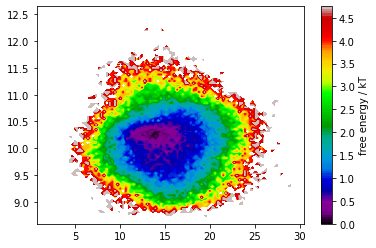

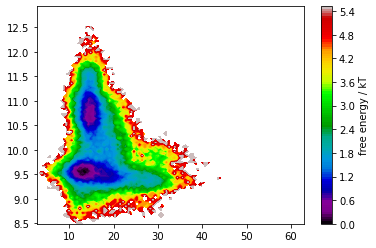

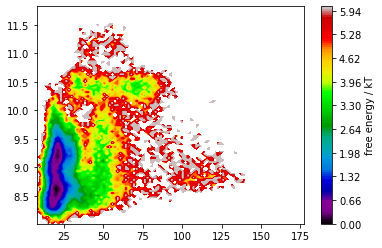

In [55]:
#ALL A
pyemma.plots.plot_free_energy(all_dh_A, all_rg_A)
#APO A
pyemma.plots.plot_free_energy(all_dh_A[:74999], all_rg_A[:74999])
#APOMG A
pyemma.plots.plot_free_energy(all_dh_A[75000:149999], all_rg_A[75000:149999])
#THM A
pyemma.plots.plot_free_energy(all_dh_A[150000:224999], all_rg_A[150000:224999])
#GCV A
pyemma.plots.plot_free_energy(all_dh_A[225000:299999], all_rg_A[225000:299999])
#THM_ATP A
pyemma.plots.plot_free_energy(all_dh_A[300000:374999], all_rg_A[300000:374999])
#GCV_ATP A
pyemma.plots.plot_free_energy(all_dh_A[375000:449999], all_rg_A[375000:449999])
#TMP_ADP A
pyemma.plots.plot_free_energy(all_dh_A[450000:524999], all_rg_A[450000:524999])
#GMP_ADP A
pyemma.plots.plot_free_energy(all_dh_A[525000:599999], all_rg_A[525000:599999])
#SR39_A
pyemma.plots.plot_free_energy(all_dh_A[600000:674999], all_rg_A[600000:674999])

In [ ]:
#ALL A
pyemma.plots.plot_free_energy(all_dh[:599999], all_rmsd[:599999])
#APO A
pyemma.plots.plot_free_energy(all_dh[:74999], all_rmsd[:74999])
#APOMG A
pyemma.plots.plot_free_energy(all_dh[75000:149999], all_rmsd[75000:149999])
#THM A
pyemma.plots.plot_free_energy(all_dh[150000:224999], all_rmsd[150000:224999])
#GCV A
pyemma.plots.plot_free_energy(all_dh[225000:299999], all_rmsd[225000:299999])
#THM_ATP A
pyemma.plots.plot_free_energy(all_dh[300000:374999], all_rmsd[300000:374999])
#GCV_ATP A
pyemma.plots.plot_free_energy(all_dh[375000:449999], all_rmsd[375000:449999])
#TMP_ADP A
pyemma.plots.plot_free_energy(all_dh[450000:524999], all_rmsd[450000:524999])
#GMP_ADP A
pyemma.plots.plot_free_energy(all_dh[525000:599999], all_rmsd[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_B[:599999], all_rg_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_B[:74999], all_rg_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_B[75000:149999], all_rg_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_B[150000:224999], all_rg_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_B[225000:299999], all_rg_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_B[300000:374999], all_rg_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_B[375000:449999], all_rg_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[450000:524999], all_rg_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[525000:599999], all_rg_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_B[:599999], all_rmsd_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_B[:74999], all_rmsd_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_B[75000:149999], all_rmsd_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_B[150000:224999], all_rmsd_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_B[225000:299999], all_rmsd_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_B[300000:374999], all_rmsd_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_B[375000:449999], all_rmsd_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[450000:524999], all_rmsd_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[525000:599999], all_rmsd_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_A[:599999], all_rmsd_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_A[:74999], all_rmsd_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_A[75000:149999], all_rmsd_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_A[150000:224999], all_rmsd_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_A[225000:299999], all_rmsd_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_A[300000:374999], all_rmsd_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_A[375000:449999], all_rmsd_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[450000:524999], all_rmsd_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[525000:599999], all_rmsd_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_A[:599999], all_rg_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_A[:74999], all_rg_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_A[75000:149999], all_rg_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_A[150000:224999], all_rg_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_A[225000:299999], all_rg_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_A[300000:374999], all_rg_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_A[375000:449999], all_rg_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[450000:524999], all_rg_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[525000:599999], all_rg_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_A[:599999], all_dh_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_A[:74999], all_dh_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_A[75000:149999], all_dh_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_A[150000:224999], all_dh_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_A[225000:299999], all_dh_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_A[300000:374999], all_dh_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_A[375000:449999], all_dh_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[450000:524999], all_dh_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_A[525000:599999], all_dh_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_B[:599999], all_rmsd_A[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_B[:74999], all_rmsd_A[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_B[75000:149999], all_rmsd_A[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_B[150000:224999], all_rmsd_A[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_B[225000:299999], all_rmsd_A[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_B[300000:374999], all_rmsd_A[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_B[375000:449999], all_rmsd_A[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[450000:524999], all_rmsd_A[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[525000:599999], all_rmsd_A[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_dh_B[:599999], all_rg_A[:599999])
#APO B
pyemma.plots.plot_free_energy(all_dh_B[:74999], all_rg_A[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_dh_B[75000:149999], all_rg_A[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_dh_B[150000:224999], all_rg_A[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_dh_B[225000:299999], all_rg_A[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_dh_B[300000:374999], all_rg_A[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_dh_B[375000:449999], all_rg_A[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[450000:524999], all_rg_A[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_dh_B[525000:599999], all_rg_A[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_rg_A[:599999], all_rg_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_rg_A[:74999], all_rg_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_rg_A[75000:149999], all_rg_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_rg_A[150000:224999], all_rg_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_rg_A[225000:299999], all_rg_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_rg_A[300000:374999], all_rg_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_rg_A[375000:449999], all_rg_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_rg_A[450000:524999], all_rg_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_rg_A[525000:599999], all_rg_B[525000:599999])

In [ ]:
#ALL B
pyemma.plots.plot_free_energy(all_rmsd_A[:599999], all_rmsd_B[:599999])
#APO B
pyemma.plots.plot_free_energy(all_rmsd_A[:74999], all_rmsd_B[:74999])
#APOMG B
pyemma.plots.plot_free_energy(all_rmsd_A[75000:149999], all_rmsd_B[75000:149999])
#THM B
pyemma.plots.plot_free_energy(all_rmsd_A[150000:224999], all_rmsd_B[150000:224999])
#GCV B
pyemma.plots.plot_free_energy(all_rmsd_A[225000:299999], all_rmsd_B[225000:299999])
#THM_ATP B
pyemma.plots.plot_free_energy(all_rmsd_A[300000:374999], all_rmsd_B[300000:374999])
#GCV_ATP B
pyemma.plots.plot_free_energy(all_rmsd_A[375000:449999], all_rmsd_B[375000:449999])
#TMP_ADP B
pyemma.plots.plot_free_energy(all_rmsd_A[450000:524999], all_rmsd_B[450000:524999])
#GMP_ADP B
pyemma.plots.plot_free_energy(all_rmsd_A[525000:599999], all_rmsd_B[525000:599999])

In [26]:
np.min(SYS5_catatp_A)

6.583929797775375

In [ ]:
#ALL B
pyemma.plots.plot_free_energy((SYS5_catglu_A), (SYS5_catatp_A))
pyemma.plots.plot_free_energy((SYS5_catglu_B), (SYS5_catatp_B))
pyemma.plots.plot_free_energy((SYS6_catglu_A), (SYS6_catatp_A))
pyemma.plots.plot_free_energy((SYS6_catglu_B), (SYS6_catatp_B))

pyemma.plots.plot_free_energy((SYS5_catglu_A), (SYS5_catatp_B))
pyemma.plots.plot_free_energy((SYS5_catglu_B), (SYS5_catatp_A))
pyemma.plots.plot_free_energy((SYS6_catglu_A), (SYS6_catatp_B))
pyemma.plots.plot_free_energy((SYS6_catglu_B), (SYS6_catatp_A))

pyemma.plots.plot_free_energy((SYS9_catglu_A), (SYS9_catatp_A))
pyemma.plots.plot_free_energy((SYS9_catglu_B), (SYS9_catatp_B))
pyemma.plots.plot_free_energy((SYS9_catglu_A), (SYS9_catatp_B))
pyemma.plots.plot_free_energy((SYS9_catglu_B), (SYS9_catatp_A))


In [ ]:
dist_pca_correl = pca_joint.feature_PC_correlation

n_argmax = 2
for ii, icorr in enumerate(dist_pca_correl.T):
    print("For PCA %u"%ii)
    argmaxs = [ii for ii in np.abs(icorr).argsort()[::-1] if not np.isnan(icorr[ii])]
    for art in argmaxs[:10]:
        print(feats[0].describe()[art])
    print()

In [31]:
import pickle

# pickle.dump(pca_Y, open ("COMPARATIVE_FEL/PCA_5-6/pca_Y.p", "wb"))
# pickle.dump(pca_joint, open ("COMPARATIVE_FEL/PCA_5-6/pca_joint.p", "wb"))
# # pickle.dump(pca_APO, open ("COMPARATIVE_FEL/PCA_1-2/pca_APO.p", "wb"))
# # pickle.dump(pca_APOMG, open ("COMPARATIVE_FEL/PCA_1-2/pca_APOMG.p", "wb"))
# #pickle.dump(pca_THM, open ("COMPARATIVE_FEL/PCA_3-4/pca_THM.p", "wb"))
# pickle.dump(pca_THM_ATP, open ("COMPARATIVE_FEL/PCA_5-6/pca_THM_ATP.p", "wb"))
# #pickle.dump(pca_THM_ADP, open ("PCA/pca_THM_ADP.p", "wb"))
# #pickle.dump(pca_GCV, open ("COMPARATIVE_FEL/PCA_3-4/pca_GCV.p", "wb"))
# pickle.dump(pca_GCV_ATP, open ("COMPARATIVE_FEL/PCA_5-6/pca_GCV_ATP.p", "wb"))
# #pickle.dump(pca_GCV_ADP, open ("PCA/pca_GCV_ADP.p", "wb"))

pickle.dump(pca_SR39, open ("COMPARATIVE_FEL/PCA_JOINT/pca_SR39.p", "wb"))
pickle.dump(pca_SR39_woATP, open ("COMPARATIVE_FEL/PCA_JOINT/pca_SR39_woATP.p", "wb"))